In [1]:
pip install yfinance pandas matplotlib numpy scikit-learn tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

In [3]:
# Download the data
data = yf.download('AAPL', start='2010-01-01', end='2025-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
data

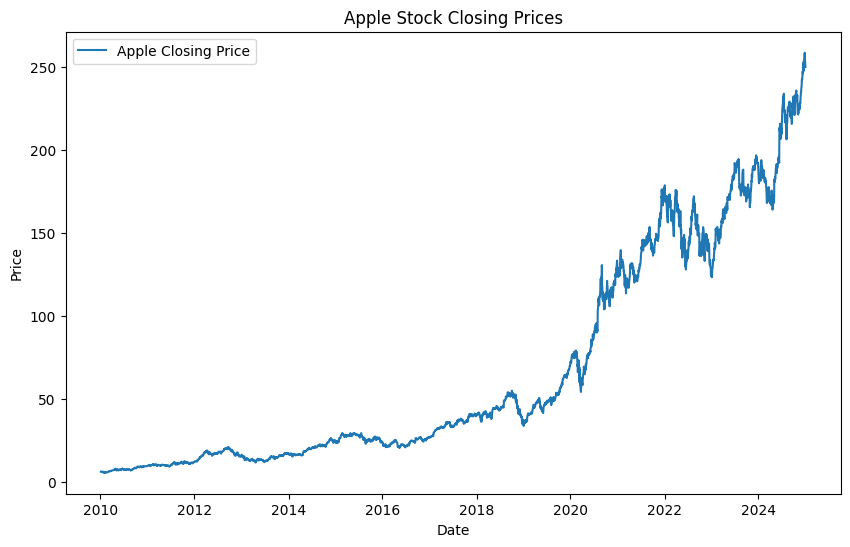

In [4]:
# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Close'], label='Apple Closing Price')
plt.title("Apple Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [5]:
data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455076,6.391278,6.422876,493729600
2010-01-05,6.451466,6.487879,6.417459,6.458086,601904800
2010-01-06,6.348846,6.477045,6.342226,6.451466,552160000
2010-01-07,6.337109,6.379843,6.291066,6.372319,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328684,447610800
...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100


In [33]:
# Data Preparation
#scaler1 = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler1.fit_transform(data)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Open'])

In [34]:
scaled_data.shape

(3774, 1)

In [35]:
# Create sequences of 60 days of stock prices as input and the next day as output
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Split into train, validation, and test sets (80%, 10%, 10%)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

In [36]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((2995, 30, 1), (2995, 1), (374, 30, 1), (374, 1), (375, 30, 1), (375, 1))

In [37]:
X_train,y_train

(array([[[2.51378501e-03],
         [2.65344460e-03],
         [2.62718758e-03],
         ...,
         [2.99601755e-04],
         [6.85144418e-04],
         [1.14230758e-03]],
 
        [[2.65344460e-03],
         [2.62718758e-03],
         [2.31325825e-03],
         ...,
         [6.85144418e-04],
         [1.14230758e-03],
         [1.41087284e-03]],
 
        [[2.62718758e-03],
         [2.31325825e-03],
         [2.14018135e-03],
         ...,
         [1.14230758e-03],
         [1.41087284e-03],
         [1.10530017e-03]],
 
        ...,
 
        [[5.91588516e-01],
         [6.07298282e-01],
         [6.05115274e-01],
         ...,
         [6.76647315e-01],
         [6.71267784e-01],
         [6.70254217e-01]],
 
        [[6.07298282e-01],
         [6.05115274e-01],
         [6.03673041e-01],
         ...,
         [6.71267784e-01],
         [6.70254217e-01],
         [6.88965540e-01]],
 
        [[6.05115274e-01],
         [6.03673041e-01],
         [5.99073154e-01],
         

In [18]:
# Transformer Model with Encoder Layer and Positional Encoding

class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=64, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Complete Transformer Model
def transformer_model(seq_len, d_model, num_heads, num_layers, dropout):
    inputs = layers.Input(shape=(seq_len, 1))

    # Embedding
    x = layers.Dense(d_model)(inputs)

    # Positional Encoding
    x = PositionalEncoding(seq_len, d_model)(x)

    # Encoder Layers
    for _ in range(num_layers):
        x = encoder_layer(units=d_model*2, d_model=d_model, num_heads=num_heads, dropout=dropout)(x)

    # Final dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    return models.Model(inputs=inputs, outputs=outputs)

# Set model parameters
d_model = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = transformer_model(sequence_length, d_model, num_heads, num_layers, dropout)
#model.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
#model.summary()

# Train the model
#history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

In [36]:
# Evaluate the model
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
# Function to calculate MAE and MAPE
def evaluate_mae_mape(y_true, y_pred):
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mae, mape

# Inverse transform to original scale
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate for training data
train_mae, train_mape = evaluate_mae_mape(y_train, train_pred)
print(f"Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

# Evaluate for validation data
val_mae, val_mape = evaluate_mae_mape(y_val, val_pred)
print(f"Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

# Evaluate for test data
test_mae, test_mape = evaluate_mae_mape(y_test, test_pred)
print(f"Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Training Data - MAE: 3.5596, MAPE: 10.68%
Validation Data - MAE: 12.8886, MAPE: 8.31%
Test Data - MAE: 12.7874, MAPE: 6.67%


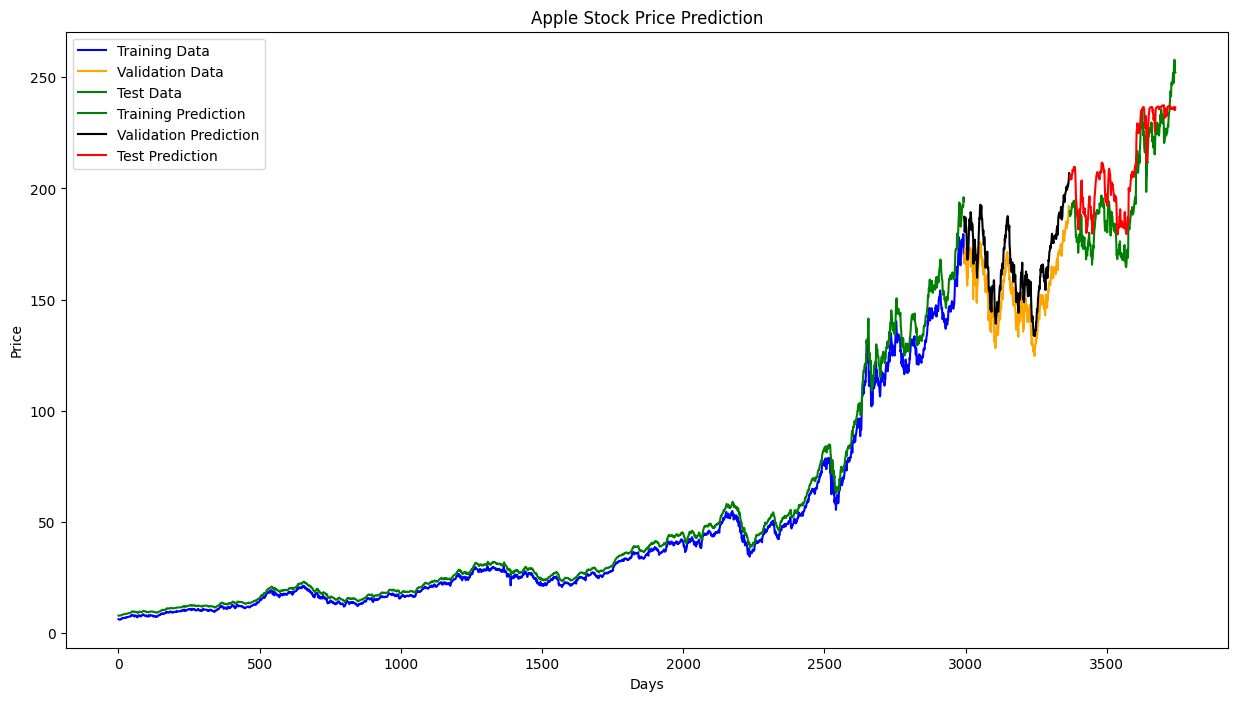

In [37]:
# Plot results
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, color='green', label='Test Data')

plt.plot(np.arange(len(train_pred)), train_pred, color='green', label='Training Prediction')
plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)), val_pred, color='black', label='Validation Prediction')
plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)), test_pred, color='red', label='Test Prediction')

plt.title("Apple Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


### using callbacks....early stopping, learning rates scheduling, checkpoints

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ModelCheckpoint to save the model with the best validation MAE
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Define Learning Rate Scheduler (Reduce LR when a plateau is reached)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

model.summary()

# Compile the model (this part remains the same)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model with early stopping, checkpoint, and learning rate scheduling
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30, 64)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_1                │ (None, 30, 64)              │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 30, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 30, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,753 (667.00 KB)

 Trainable params: 170,753 (667.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1708 - mae: 0.2712
Epoch 1: val_loss improved from inf to 0.01338, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 0.1696 - mae: 0.2698 - val_loss: 0.0134 - val_mae: 0.1094 - learning_rate: 0.0010
Epoch 2/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0287
Epoch 2: val_loss improved from 0.01338 to 0.00238, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 0.0024 - val_mae: 0.0386 - learning_rate: 0.0010
Epoch 3/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0264
Epoch 3: val_loss improved from 0.00238 to 0.00134, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - mae: 0.0265 - val_loss: 0.0013 - val_mae: 0.0307 - learning_rate: 0.0010
Epoch 4/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - mae: 0.0253
Epoch 4: val_loss did not improve from 0.00134
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - mae: 0.0253 - val_loss: 0.0033 - val_mae: 0.0471 - learning_rate: 0.0010
Epoch 5/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - mae: 0.0253
Epoch 5: val_loss did not improve from 0.00134
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - mae: 0.0252 - val_loss: 0.0018 - val_mae: 0.0332 - learning_rate: 0.0010
Epoch 6/50
84/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4320e-04 - mae: 0.0233
Epoch 6: val_loss did not improve from 0.00134
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3601e-04 - mae: 0.0231 - val_loss: 0.0023 - val_mae: 0.0379 - learning_rate: 0.0010
Epoch 7/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0517e-04 - mae: 0.0221
Epoch 7: val_lo


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9339e-04 - mae: 0.0219 - val_loss: 0.0013 - val_mae: 0.0292 - learning_rate: 0.0010
Epoch 9/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9345e-04 - mae: 0.0175
Epoch 9: val_loss did not improve from 0.00133
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9481e-04 - mae: 0.0175 - val_loss: 0.0019 - val_mae: 0.0343 - learning_rate: 5.0000e-04
Epoch 10/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4294e-04 - mae: 0.0183
Epoch 10: val_loss did not improve from 0.00133
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4220e-04 - mae: 0.0182 - val_loss: 0.0017 - val_mae: 0.0324 - learning_rate: 5.0000e-04
Epoch 11/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2097e-04 - mae: 0.0195
Epoch 11: val_loss did not improve from 0.00133
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2046e-04 - mae: 0.0195 - val_loss: 0.0016 - val_mae: 0.0311 - learning_ra


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5184e-04 - mae: 0.0165 - val_loss: 0.0013 - val_mae: 0.0280 - learning_rate: 5.0000e-04
Epoch 14/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7214e-04 - mae: 0.0150
Epoch 14: val_loss did not improve from 0.00129
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7332e-04 - mae: 0.0150 - val_loss: 0.0013 - val_mae: 0.0282 - learning_rate: 2.5000e-04
Epoch 15/50
84/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5230e-04 - mae: 0.0165
Epoch 15: val_loss did not improve from 0.00129
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4724e-04 - mae: 0.0165 - val_loss: 0.0015 - val_mae: 0.0309 - learning_rate: 2.5000e-04
Epoch 16/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6251e-04 - mae: 0.0148
Epoch 16: val_loss improved from 0.00129 to 0.00117, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6335e-04 - mae: 0.0149 - val_loss: 0.0012 - val_mae: 0.0266 - learning_rate: 2.5000e-04
Epoch 17/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5739e-04 - mae: 0.0146
Epoch 17: val_loss improved from 0.00117 to 0.00073, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5656e-04 - mae: 0.0146 - val_loss: 7.2716e-04 - val_mae: 0.0212 - learning_rate: 2.5000e-04
Epoch 18/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5312e-04 - mae: 0.0148
Epoch 18: val_loss did not improve from 0.00073
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5289e-04 - mae: 0.0148 - val_loss: 0.0016 - val_mae: 0.0326 - learning_rate: 2.5000e-04
Epoch 19/50
85/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0552e-04 - mae: 0.0159
Epoch 19: val_loss did not improve from 0.00073
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0271e-04 - mae: 0.0159 - val_loss: 9.2008e-04 - val_mae: 0.0237 - learning_rate: 2.5000e-04
Epoch 20/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0147e-04 - mae: 0.0136
Epoch 20: val_loss did not improve from 0.00073
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0177e-04 - mae: 0.0136 - val_loss: 0.0011 - val_mae: 0.0274 - learning_rate: 2.5000e-04
Epoch 21/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1175e-04 - mae: 0.0137 - val_loss: 4.2590e-04 - val_mae: 0.0160 - learning_rate: 2.5000e-04
Epoch 22/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7929e-04 - mae: 0.0132
Epoch 22: val_loss did not improve from 0.00043
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7907e-04 - mae: 0.0132 - val_loss: 6.3868e-04 - val_mae: 0.0199 - learning_rate: 2.5000e-04
Epoch 23/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1148e-04 - mae: 0.0139
Epoch 23: val_loss did not improve from 0.00043
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1042e-04 - mae: 0.0139 - val_loss: 5.2406e-04 - val_mae: 0.0179 - learning_rate: 2.5000e-04
Epoch 24/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4259e-04 - mae: 0.0122
Epoch 24: val_loss did not improve from 0.00043
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4296e-04 - mae: 0.0122 - val_loss: 8.3609e-04 - val_mae: 0.0246 - learning_rate: 2.5000e-04
Epoch 25/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4135e-04 - mae: 0.0123 - val_loss: 3.2148e-04 - val_mae: 0.0141 - learning_rate: 2.5000e-04
Epoch 27/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0999e-04 - mae: 0.0114
Epoch 27: val_loss did not improve from 0.00032
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0989e-04 - mae: 0.0114 - val_loss: 4.0472e-04 - val_mae: 0.0162 - learning_rate: 2.5000e-04
Epoch 28/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9326e-04 - mae: 0.0110
Epoch 28: val_loss did not improve from 0.00032
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9352e-04 - mae: 0.0110 - val_loss: 3.2843e-04 - val_mae: 0.0145 - learning_rate: 2.5000e-04
Epoch 29/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4835e-04 - mae: 0.0125
Epoch 29: val_loss improved from 0.00032 to 0.00022, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.4851e-04 - mae: 0.0125 - val_loss: 2.2186e-04 - val_mae: 0.0119 - learning_rate: 2.5000e-04
Epoch 30/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6175e-04 - mae: 0.0127
Epoch 30: val_loss improved from 0.00022 to 0.00020, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6279e-04 - mae: 0.0128 - val_loss: 1.9922e-04 - val_mae: 0.0111 - learning_rate: 2.5000e-04
Epoch 31/50
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2026e-04 - mae: 0.0118
Epoch 31: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1886e-04 - mae: 0.0117 - val_loss: 2.3321e-04 - val_mae: 0.0122 - learning_rate: 2.5000e-04
Epoch 32/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0928e-04 - mae: 0.0139
Epoch 32: val_loss did not improve from 0.00020
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0680e-04 - mae: 0.0139 - val_loss: 3.6991e-04 - val_mae: 0.0156 - learning_rate: 2.5000e-04
Epoch 33/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9237e-04 - mae: 0.0109
Epoch 33: val_loss improved from 0.00020 to 0.00019, saving model to best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9220e-04 - mae: 0.0109 - val_loss: 1.8669e-04 - val_mae: 0.0108 - learning_rate: 2.5000e-04
Epoch 34/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0321e-04 - mae: 0.0113
Epoch 34: val_loss did not improve from 0.00019
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0324e-04 - mae: 0.0113 - val_loss: 2.5689e-04 - val_mae: 0.0129 - learning_rate: 2.5000e-04
Epoch 35/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3056e-04 - mae: 0.0121
Epoch 35: val_loss improved from 0.00019 to 0.00017, saving model to best_model.h5



Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3033e-04 - mae: 0.0121 - val_loss: 1.6895e-04 - val_mae: 0.0101 - learning_rate: 2.5000e-04
Epoch 36/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9098e-04 - mae: 0.0108
Epoch 36: val_loss did not improve from 0.00017
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8966e-04 - mae: 0.0108 - val_loss: 2.4692e-04 - val_mae: 0.0126 - learning_rate: 1.2500e-04
Epoch 37/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6070e-04 - mae: 0.0099
Epoch 37: val_loss did not improve from 0.00017
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6066e-04 - mae: 0.0099 - val_loss: 4.9785e-04 - val_mae: 0.0189 - learning_rate: 1.2500e-04
Epoch 38/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5345e-04 - mae: 0.0098
Epoch 38: val_loss did not improve from 0.00017
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5356e-04 - mae: 0.0098 - val_loss: 7.3669e-04 - val_ma

In [22]:
# Recreate model and load weights
from tensorflow.keras import models, layers, optimizers

d_model = 64
num_heads = 4
num_layers = 2
dropout = 0.1
sequence_length = 30

# Recreate the model
new_model = transformer_model(sequence_length, d_model, num_heads, num_layers, dropout)

# Try to load just the weights
try:
    new_model.load_weights('best_model.h5')
    print("Weights loaded successfully!")
    model = new_model
except Exception as e:
    print(f"Error loading weights: {e}")

Weights loaded successfully!


In [31]:
# Evaluate the model
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error
# Function to calculate MAE and MAPE
def evaluate_mae_mape(y_true, y_pred):
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mae, mape

# Inverse transform to original scale
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate for training data
train_mae, train_mape = evaluate_mae_mape(y_train, train_pred)
print(f"Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

# Evaluate for validation data
val_mae, val_mape = evaluate_mae_mape(y_val, val_pred)
print(f"Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

# Evaluate for test data
test_mae, test_mape = evaluate_mae_mape(y_test, test_pred)
print(f"Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training Data - MAE: 2.6502, MAPE: 13.19%
Validation Data - MAE: 2.5375, MAPE: 1.67%
Test Data - MAE: 8.2392, MAPE: 3.77%


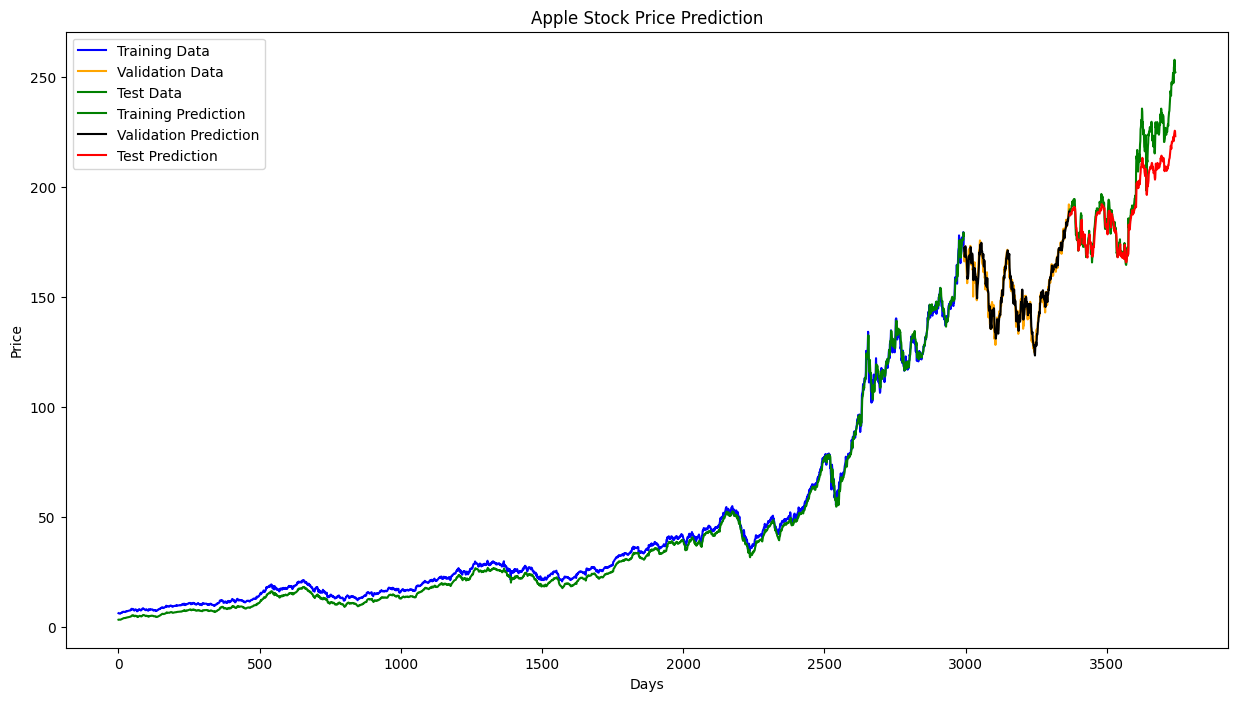

In [32]:
# Plot results
plt.figure(figsize=(15,8))
plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, color='green', label='Test Data')

plt.plot(np.arange(len(train_pred)), train_pred, color='green', label='Training Prediction')
plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)), val_pred, color='black', label='Validation Prediction')
plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)), test_pred, color='red', label='Test Prediction')

plt.title("Apple Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [40]:
from tensorflow.keras.losses import MeanSquaredError

# Model Architectures

def rnn_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.SimpleRNN(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.SimpleRNN(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def lstm_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.LSTM(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def gru_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.GRU(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.GRU(units)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def bidirectional_lstm_model(seq_len, feature_dim=1, units=64):
    inputs = layers.Input(shape=(seq_len, feature_dim))

    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Training function
def train_model(model_func, model_name, X_train, y_train, X_val, y_val, sequence_length, epochs=50, batch_size=32):
    # Create model
    model = model_func(sequence_length)

    # Print model summary
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=5,
                                min_lr=1e-6,
                                verbose=1)
    callbacks = [early_stopping, checkpoint, reduce_lr]

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        callbacks=callbacks
    )

    # Load the best model
    model = tf.keras.models.load_model(f'best_{model_name}_model.h5')

    return model, history

# Evaluation function
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    # Function to calculate MAE and MAPE
    def evaluate_mae_mape(y_true, y_pred):
        # Calculate MAE
        mae = mean_absolute_error(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        return mae, mape

    # Inverse transform to original scale
    train_pred = scaler.inverse_transform(train_pred)
    val_pred = scaler.inverse_transform(val_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate for training data
    train_mae, train_mape = evaluate_mae_mape(y_train_orig, train_pred)
    print(f"{model_name} - Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

    # Evaluate for validation data
    val_mae, val_mape = evaluate_mae_mape(y_val_orig, val_pred)
    print(f"{model_name} - Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

    # Evaluate for test data
    test_mae, test_mape = evaluate_mae_mape(y_test_orig, test_pred)
    print(f"{model_name} - Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

    results = {
        'train_pred': train_pred,
        'val_pred': val_pred,
        'test_pred': test_pred,
        'y_train': y_train_orig,
        'y_val': y_val_orig,
        'y_test': y_test_orig,
        'metrics': {
            'train_mae': train_mae,
            'train_mape': train_mape,
            'val_mae': val_mae,
            'val_mape': val_mape,
            'test_mae': test_mae,
            'test_mape': test_mape
        }
    }

    return results

# Visualization function
def plot_predictions(results, model_name, stock_name="Stock"):
    # Extract data
    y_train = results['y_train']
    y_val = results['y_val']
    y_test = results['y_test']
    train_pred = results['train_pred']
    val_pred = results['val_pred']
    test_pred = results['test_pred']

    # Plot results
    plt.figure(figsize=(15, 8))

    # Actual data
    plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)),
             y_test, color='green', label='Test Data')

    # Predictions
    plt.plot(np.arange(len(train_pred)), train_pred, color='lightgreen', linestyle='--', label='Training Prediction')
    plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)),
             val_pred, color='black', linestyle='--', label='Validation Prediction')
    plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)),
             test_pred, color='red', linestyle='--', label='Test Prediction')

    plt.title(f"{stock_name} Price Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_prediction.png")
    plt.show()

# Compare model performances
def compare_models(model_results, stock_name="Stock"):
    models = list(model_results.keys())

    # Create metrics dataframe
    metrics_data = []
    for model_name, results in model_results.items():
        metrics = results['metrics']
        metrics_data.append({
            'Model': model_name,
            'Train MAE': metrics['train_mae'],
            'Train MAPE (%)': metrics['train_mape'],
            'Val MAE': metrics['val_mae'],
            'Val MAPE (%)': metrics['val_mape'],
            'Test MAE': metrics['test_mae'],
            'Test MAPE (%)': metrics['test_mape']
        })

    metrics_df = pd.DataFrame(metrics_data)
    print("\nModel Performance Comparison:")
    print(metrics_df)

    # Plot MAE comparison
    plt.figure(figsize=(14, 6))

    # Bar chart for MAE
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))
    width = 0.2

    plt.bar(x - width, [model_results[m]['metrics']['train_mae'] for m in models],
            width, label='Train MAE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mae'] for m in models],
            width, label='Val MAE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mae'] for m in models],
            width, label='Test MAE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'{stock_name} Price Prediction - MAE Comparison')
    plt.xticks(x, models)
    plt.legend()

    # Bar chart for MAPE
    plt.subplot(1, 2, 2)
    plt.bar(x - width, [model_results[m]['metrics']['train_mape'] for m in models],
            width, label='Train MAPE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mape'] for m in models],
            width, label='Val MAPE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mape'] for m in models],
            width, label='Test MAPE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAPE (%)')
    plt.title(f'{stock_name} Price Prediction - MAPE Comparison')
    plt.xticks(x, models)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{stock_name}_model_comparison.png")
    plt.show()

    return metrics_df

# Main function to run the entire process
def run_models(X_train, y_train, X_val, y_val, X_test, y_test,
               sequence_length, scaler, epochs=50, batch_size=32, stock_name="Apple"):
    # Model architectures dictionary
    model_builders = {
        'RNN': rnn_model,
        'LSTM': lstm_model,
        'GRU': gru_model,
        'BiLSTM': bidirectional_lstm_model
    }

    # Train and evaluate all models
    model_results = {}
    for model_name, model_func in model_builders.items():
        # Train
        trained_model, history = train_model(
            model_func, model_name, X_train, y_train, X_val, y_val,
            sequence_length, epochs, batch_size
        )

        # Evaluate
        results = evaluate_model(
            trained_model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, scaler
        )

        # Store results
        model_results[model_name] = results

        # Plot individual model results
        plot_predictions(results, model_name, stock_name)

    # Compare all models
    metrics_df = compare_models(model_results, stock_name)

    return model_results, metrics_df


Training RNN model...


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 30, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0207 - mae: 0.0778
Epoch 1: val_loss improved from inf to 0.01367, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0206 - mae: 0.0775 - val_loss: 0.0137 - val_mae: 0.1133 - learning_rate: 0.0010
Epoch 2/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6407e-04 - mae: 0.0194
Epoch 2: val_loss improved from 0.01367 to 0.00363, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5924e-04 - mae: 0.0194 - val_loss: 0.0036 - val_mae: 0.0550 - learning_rate: 0.0010
Epoch 3/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5666e-04 - mae: 0.0161
Epoch 3: val_loss did not improve from 0.00363
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5704e-04 - mae: 0.0161 - val_loss: 0.0038 - val_mae: 0.0562 - learning_rate: 0.0010
Epoch 4/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4215e-04 - mae: 0.0142
Epoch 4: val_loss improved from 0.00363 to 0.00150, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3999e-04 - mae: 0.0142 - val_loss: 0.0015 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 5/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7158e-04 - mae: 0.0137
Epoch 5: val_loss improved from 0.00150 to 0.00137, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7048e-04 - mae: 0.0137 - val_loss: 0.0014 - val_mae: 0.0323 - learning_rate: 0.0010
Epoch 6/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9171e-04 - mae: 0.0120
Epoch 6: val_loss did not improve from 0.00137
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9142e-04 - mae: 0.0120 - val_loss: 0.0018 - val_mae: 0.0366 - learning_rate: 0.0010
Epoch 7/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2977e-04 - mae: 0.0109
Epoch 7: val_loss did not improve from 0.00137
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2955e-04 - mae: 0.0109 - val_loss: 0.0017 - val_mae: 0.0361 - learning_rate: 0.0010
Epoch 8/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5555e-04 - mae: 0.0117
Epoch 8: val_loss improved from 0.00137 to 0.00081, saving model to best_RNN_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5566e-04 - mae: 0.0117 - val_loss: 8.0837e-04 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 9/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6494e-04 - mae: 0.0099
Epoch 9: val_loss did not improve from 0.00081
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6725e-04 - mae: 0.0100 - val_loss: 0.0024 - val_mae: 0.0447 - learning_rate: 0.0010
Epoch 10/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6390e-04 - mae: 0.0100
Epoch 10: val_loss did not improve from 0.00081
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6433e-04 - mae: 0.0100 - val_loss: 0.0048 - val_mae: 0.0661 - learning_rate: 0.0010
Epoch 11/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5381e-04 - mae: 0.0094
Epoch 11: val_loss did not improve from 0.00081
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5426e-04 - mae: 0.0094 - val_loss: 9.2276e-04 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 12/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6195e

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8982e-04 - mae: 0.0085 - val_loss: 6.8980e-04 - val_mae: 0.0216 - learning_rate: 5.0000e-04
Epoch 17/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1059e-04 - mae: 0.0081
Epoch 17: val_loss did not improve from 0.00069
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1009e-04 - mae: 0.0081 - val_loss: 9.7503e-04 - val_mae: 0.0265 - learning_rate: 5.0000e-04
Epoch 18/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8399e-04 - mae: 0.0080
Epoch 18: val_loss did not improve from 0.00069
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8406e-04 - mae: 0.0080 - val_loss: 7.2592e-04 - val_mae: 0.0223 - learning_rate: 5.0000e-04
Epoch 19/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5620e-04 - mae: 0.0077
Epoch 19: val_loss did not improve from 0.00069
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5620e-04 - mae: 0.0077 - val_loss: 0.0024 - val_mae: 0.0453 - learning_rate: 5.0000e-04
Epoch 20/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7893e-04 - mae: 0.0080 - val_loss: 4.1122e-04 - val_mae: 0.0163 - learning_rate: 5.0000e-04
Epoch 22/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2141e-04 - mae: 0.0089
Epoch 22: val_loss did not improve from 0.00041
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2143e-04 - mae: 0.0088 - val_loss: 8.8503e-04 - val_mae: 0.0251 - learning_rate: 5.0000e-04
Epoch 23/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6206e-04 - mae: 0.0077
Epoch 23: val_loss did not improve from 0.00041
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6281e-04 - mae: 0.0077 - val_loss: 0.0016 - val_mae: 0.0357 - learning_rate: 5.0000e-04
Epoch 24/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9697e-04 - mae: 0.0082
Epoch 24: val_loss did not improve from 0.00041
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9621e-04 - mae: 0.0082 - val_loss: 4.8826e-04 - val_mae: 0.0179 - learning_rate: 5.0000e-04
Epoch 25/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
RNN - Training Data - MAE: 1.2446, MAPE: 4.27%
RNN - Validation Data - MAE: 4.1213, MAPE: 2.63%
RNN - Test Data - MAE: 14.8238, MAPE: 7.01%


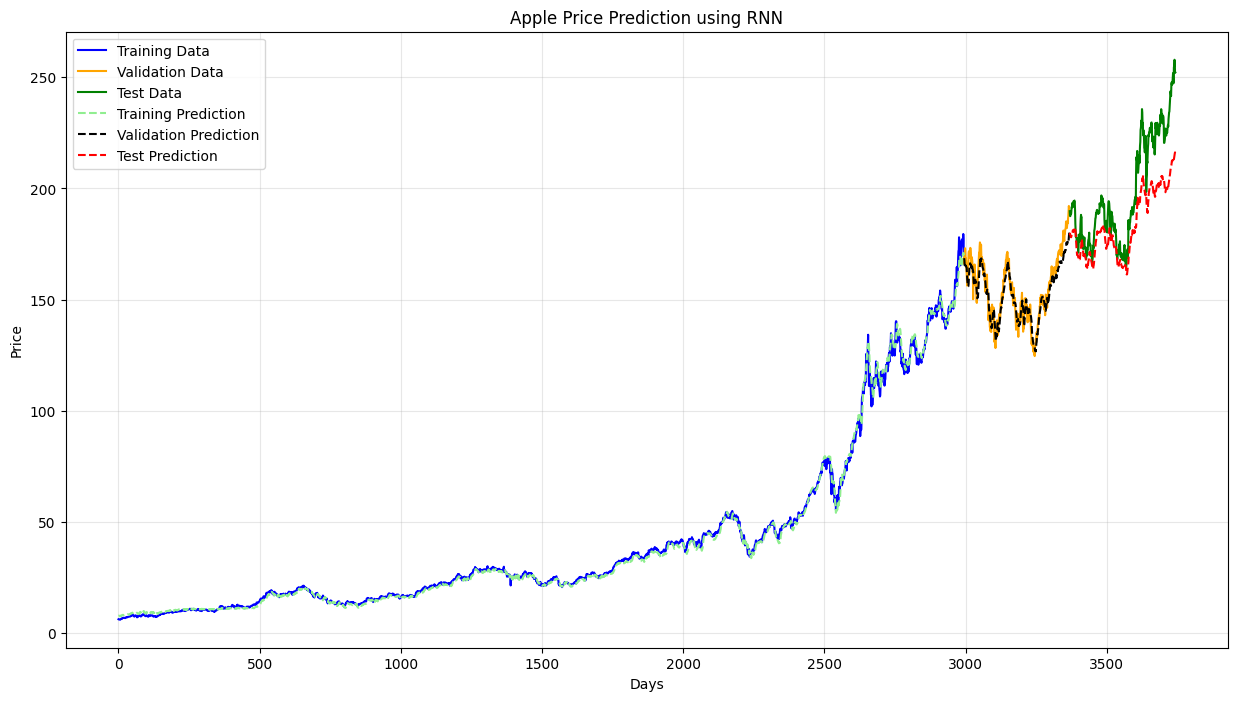


Training LSTM model...


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - mae: 0.0456
Epoch 1: val_loss improved from inf to 0.00191, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0088 - mae: 0.0453 - val_loss: 0.0019 - val_mae: 0.0357 - learning_rate: 0.0010
Epoch 2/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7298e-04 - mae: 0.0097
Epoch 2: val_loss improved from 0.00191 to 0.00087, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.7233e-04 - mae: 0.0097 - val_loss: 8.6533e-04 - val_mae: 0.0251 - learning_rate: 0.0010
Epoch 3/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3329e-04 - mae: 0.0088
Epoch 3: val_loss improved from 0.00087 to 0.00069, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3287e-04 - mae: 0.0088 - val_loss: 6.9276e-04 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 4/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1050e-04 - mae: 0.0086
Epoch 4: val_loss did not improve from 0.00069
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1124e-04 - mae: 0.0087 - val_loss: 0.0015 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0400e-04 - mae: 0.0084
Epoch 5: val_loss improved from 0.00069 to 0.00065, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0443e-04 - mae: 0.0084 - val_loss: 6.5169e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 6/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8631e-04 - mae: 0.0078
Epoch 6: val_loss improved from 0.00065 to 0.00060, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8729e-04 - mae: 0.0078 - val_loss: 5.9739e-04 - val_mae: 0.0209 - learning_rate: 0.0010
Epoch 7/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7573e-04 - mae: 0.0109
Epoch 7: val_loss did not improve from 0.00060
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7473e-04 - mae: 0.0109 - val_loss: 0.0014 - val_mae: 0.0316 - learning_rate: 0.0010
Epoch 8/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8657e-04 - mae: 0.0081
Epoch 8: val_loss improved from 0.00060 to 0.00051, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8617e-04 - mae: 0.0081 - val_loss: 5.1307e-04 - val_mae: 0.0191 - learning_rate: 0.0010
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8013e-04 - mae: 0.0078
Epoch 9: val_loss did not improve from 0.00051
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8006e-04 - mae: 0.0078 - val_loss: 0.0011 - val_mae: 0.0280 - learning_rate: 0.0010
Epoch 10/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7475e-04 - mae: 0.0084
Epoch 10: val_loss did not improve from 0.00051
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7498e-04 - mae: 0.0084 - val_loss: 5.8233e-04 - val_mae: 0.0190 - learning_rate: 0.0010
Epoch 11/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6667e-04 - mae: 0.0076
Epoch 11: val_loss did not improve from 0.00051
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6668e-04 - mae: 0.0076 - val_loss: 5.6780e-04 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 12/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5883e-04 - mae: 0.0074 - val_loss: 4.8646e-04 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 13/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5206e-04 - mae: 0.0072
Epoch 13: val_loss improved from 0.00049 to 0.00047, saving model to best_LSTM_model.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5227e-04 - mae: 0.0072 - val_loss: 4.7034e-04 - val_mae: 0.0183 - learning_rate: 0.0010
Epoch 14/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4181e-04 - mae: 0.0070
Epoch 14: val_loss improved from 0.00047 to 0.00046, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4086e-04 - mae: 0.0070 - val_loss: 4.5714e-04 - val_mae: 0.0180 - learning_rate: 5.0000e-04
Epoch 15/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0573e-04 - mae: 0.0061
Epoch 15: val_loss did not improve from 0.00046
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0662e-04 - mae: 0.0061 - val_loss: 7.4235e-04 - val_mae: 0.0229 - learning_rate: 5.0000e-04
Epoch 16/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3048e-04 - mae: 0.0067
Epoch 16: val_loss improved from 0.00046 to 0.00044, saving model to best_LSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3021e-04 - mae: 0.0067 - val_loss: 4.4049e-04 - val_mae: 0.0176 - learning_rate: 5.0000e-04
Epoch 17/50
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2554e-04 - mae: 0.0066
Epoch 17: val_loss did not improve from 0.00044
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2534e-04 - mae: 0.0066 - val_loss: 6.4802e-04 - val_mae: 0.0214 - learning_rate: 5.0000e-04
Epoch 18/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3274e-04 - mae: 0.0067
Epoch 18: val_loss did not improve from 0.00044

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3252e-04 - mae: 0.0067 - val_loss: 4.9026e-04 - val_mae: 0.0174 - learning_rate: 5.0000e-04
Epoch 19/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0757e-04 - mae: 0.0062
Epoch 19: val_loss did not improve from 0.00044
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0750e-04 - mae: 0.0062 - val_loss: 9.7863e-04 - val

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0384e-04 - mae: 0.0059 - val_loss: 3.9218e-04 - val_mae: 0.0162 - learning_rate: 2.5000e-04
Epoch 24/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.8882e-05 - mae: 0.0057
Epoch 24: val_loss did not improve from 0.00039
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8991e-05 - mae: 0.0057 - val_loss: 0.0011 - val_mae: 0.0285 - learning_rate: 2.5000e-04
Epoch 25/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0885e-04 - mae: 0.0060
Epoch 25: val_loss did not improve from 0.00039
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0885e-04 - mae: 0.0060 - val_loss: 6.3110e-04 - val_mae: 0.0211 - learning_rate: 2.5000e-04
Epoch 26/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3049e-05 - mae: 0.0056
Epoch 26: val_loss did not improve from 0.00039
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.3754e-05 - mae: 0.0056 - val_loss: 0.0011 - val_mae: 0.0288 - learning_rate: 2.5000e-04
Epoch 27/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM - Training Data - MAE: 1.0816, MAPE: 3.23%
LSTM - Validation Data - MAE: 4.0864, MAPE: 2.69%
LSTM - Test Data - MAE: 4.5922, MAPE: 2.28%


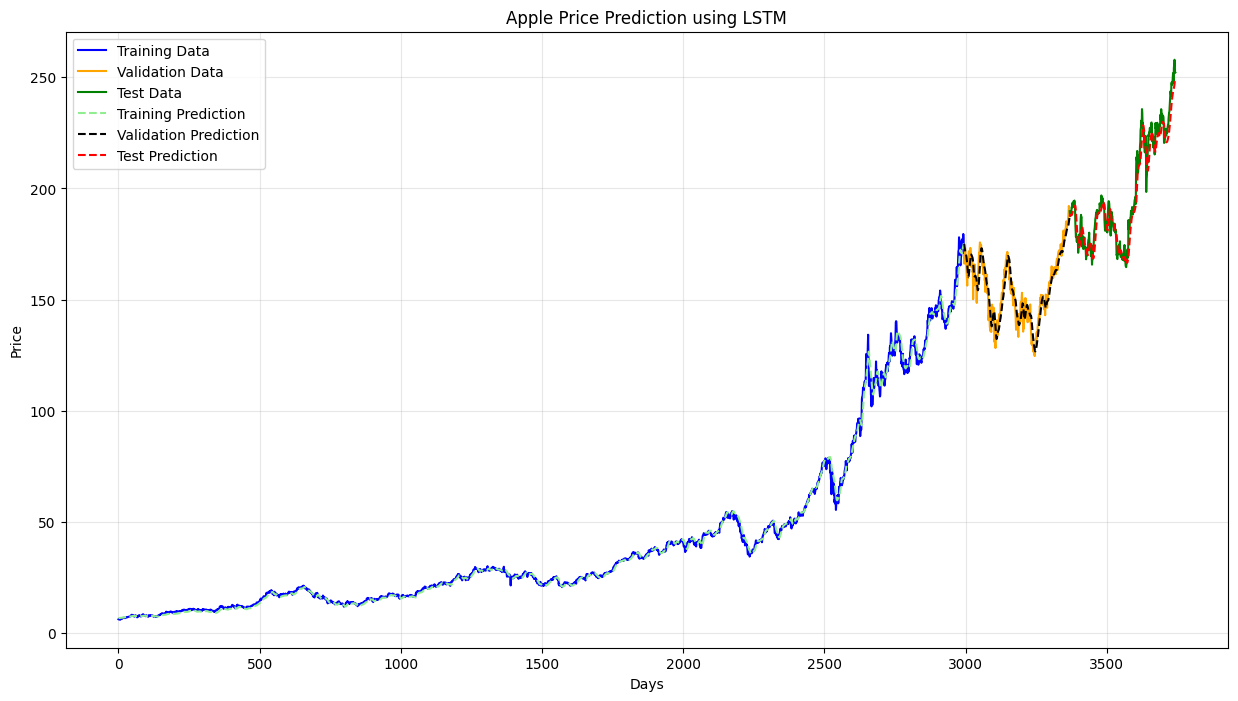


Training GRU model...


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,937 (156.00 KB)

 Trainable params: 39,937 (156.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - mae: 0.0385
Epoch 1: val_loss improved from inf to 0.00041, saving model to best_GRU_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0050 - mae: 0.0377 - val_loss: 4.0800e-04 - val_mae: 0.0169 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4948e-04 - mae: 0.0097
Epoch 2: val_loss did not improve from 0.00041
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4923e-04 - mae: 0.0097 - val_loss: 4.2135e-04 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 3/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9168e-04 - mae: 0.0088
Epoch 3: val_loss did not improve from 0.00041
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9126e-04 - mae: 0.0088 - val_loss: 6.1800e-04 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 4/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7846e-04 - mae: 0.0088
Epoch 4: val_loss did not improve from 0.00041
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7911e-04 - mae: 0.0088 - val_loss: 5.0632e-04 - val_mae: 0.0190 - learning_rate: 0.0010
Epoch 5/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6366e-04 - mae: 0.0078 - val_loss: 3.9351e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 6/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7799e-04 - mae: 0.0081
Epoch 6: val_loss improved from 0.00039 to 0.00034, saving model to best_GRU_model.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7780e-04 - mae: 0.0081 - val_loss: 3.4010e-04 - val_mae: 0.0153 - learning_rate: 0.0010
Epoch 7/50
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4831e-04 - mae: 0.0068
Epoch 7: val_loss did not improve from 0.00034
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4835e-04 - mae: 0.0069 - val_loss: 3.4076e-04 - val_mae: 0.0153 - learning_rate: 5.0000e-04
Epoch 8/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7625e-05 - mae: 0.0059
Epoch 8: val_loss did not improve from 0.00034
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8082e-05 - mae: 0.0059 - val_loss: 3.7211e-04 - val_mae: 0.0150 - learning_rate: 5.0000e-04
Epoch 9/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4171e-04 - mae: 0.0072
Epoch 9: val_loss did not improve from 0.00034
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4112e-04 - mae: 0.0072 - val_loss: 5.1163e-04 - val_mae: 0.0192

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
GRU - Training Data - MAE: 0.9423, MAPE: 2.63%
GRU - Validation Data - MAE: 3.8553, MAPE: 2.49%
GRU - Test Data - MAE: 4.9307, MAPE: 2.43%


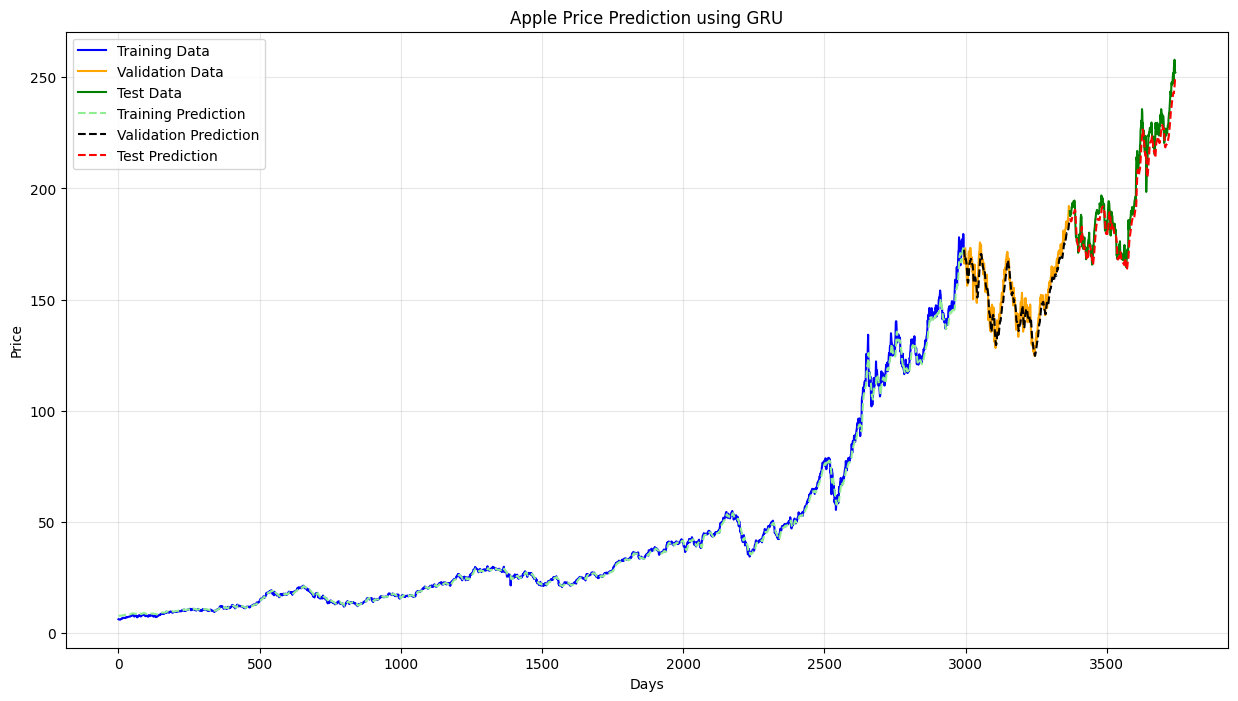


Training BiLSTM model...


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 30, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,769 (534.25 KB)

 Trainable params: 136,769 (534.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070 - mae: 0.0439
Epoch 1: val_loss improved from inf to 0.00147, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0070 - mae: 0.0437 - val_loss: 0.0015 - val_mae: 0.0303 - learning_rate: 0.0010
Epoch 2/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6952e-04 - mae: 0.0098
Epoch 2: val_loss did not improve from 0.00147
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7005e-04 - mae: 0.0098 - val_loss: 0.0015 - val_mae: 0.0298 - learning_rate: 0.0010
Epoch 3/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4468e-04 - mae: 0.0094
Epoch 3: val_loss improved from 0.00147 to 0.00109, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.4439e-04 - mae: 0.0093 - val_loss: 0.0011 - val_mae: 0.0257 - learning_rate: 0.0010
Epoch 4/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9119e-04 - mae: 0.0104
Epoch 4: val_loss improved from 0.00109 to 0.00088, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.9001e-04 - mae: 0.0104 - val_loss: 8.8078e-04 - val_mae: 0.0232 - learning_rate: 0.0010
Epoch 5/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7438e-04 - mae: 0.0077
Epoch 5: val_loss improved from 0.00088 to 0.00069, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7488e-04 - mae: 0.0077 - val_loss: 6.9147e-04 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 6/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7202e-04 - mae: 0.0100
Epoch 6: val_loss improved from 0.00069 to 0.00059, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.7074e-04 - mae: 0.0099 - val_loss: 5.9356e-04 - val_mae: 0.0198 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6141e-04 - mae: 0.0073
Epoch 7: val_loss did not improve from 0.00059
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6142e-04 - mae: 0.0073 - val_loss: 9.5031e-04 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 8/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4611e-04 - mae: 0.0068
Epoch 8: val_loss did not improve from 0.00059
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.4612e-04 - mae: 0.0068 - val_loss: 6.5142e-04 - val_mae: 0.0196 - learning_rate: 0.0010
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3646e-04 - mae: 0.0070
Epoch 9: val_loss did not improve from 0.00059
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.3652e-04 - mae: 0.0070 - val_loss: 6.6024e-04 - val_mae: 0.0198 - learning_rate: 0.0010
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - l

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4414e-04 - mae: 0.0073 - val_loss: 3.9827e-04 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 11/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3816e-04 - mae: 0.0072
Epoch 11: val_loss did not improve from 0.00040
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.3833e-04 - mae: 0.0072 - val_loss: 5.2047e-04 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 12/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6725e-04 - mae: 0.0078
Epoch 12: val_loss did not improve from 0.00040
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6695e-04 - mae: 0.0078 - val_loss: 4.0683e-04 - val_mae: 0.0159 - learning_rate: 0.0010
Epoch 13/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2830e-04 - mae: 0.0065
Epoch 13: val_loss did not improve from 0.00040
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.2824e-04 - mae: 0.0065 - val_loss: 5.4986e-04 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 14/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.0289e-04 - mae: 0.0064 - val_loss: 3.6152e-04 - val_mae: 0.0150 - learning_rate: 5.0000e-04
Epoch 18/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.1765e-05 - mae: 0.0057
Epoch 18: val_loss did not improve from 0.00036
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.1935e-05 - mae: 0.0057 - val_loss: 5.3310e-04 - val_mae: 0.0178 - learning_rate: 5.0000e-04
Epoch 19/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9695e-05 - mae: 0.0058
Epoch 19: val_loss improved from 0.00036 to 0.00032, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.9603e-05 - mae: 0.0058 - val_loss: 3.2008e-04 - val_mae: 0.0143 - learning_rate: 5.0000e-04
Epoch 20/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9381e-05 - mae: 0.0055
Epoch 20: val_loss did not improve from 0.00032

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.9306e-05 - mae: 0.0055 - val_loss: 3.6634e-04 - val_mae: 0.0156 - learning_rate: 5.0000e-04
Epoch 21/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5200e-05 - mae: 0.0055
Epoch 21: val_loss improved from 0.00032 to 0.00031, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.5245e-05 - mae: 0.0055 - val_loss: 3.1436e-04 - val_mae: 0.0142 - learning_rate: 2.5000e-04
Epoch 22/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9052e-05 - mae: 0.0056
Epoch 22: val_loss did not improve from 0.00031
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.9094e-05 - mae: 0.0056 - val_loss: 3.3284e-04 - val_mae: 0.0143 - learning_rate: 2.5000e-04
Epoch 23/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.3162e-05 - mae: 0.0053
Epoch 23: val_loss improved from 0.00031 to 0.00031, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.3154e-05 - mae: 0.0053 - val_loss: 3.0673e-04 - val_mae: 0.0137 - learning_rate: 2.5000e-04
Epoch 24/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7736e-05 - mae: 0.0050
Epoch 24: val_loss did not improve from 0.00031
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.7842e-05 - mae: 0.0050 - val_loss: 3.7112e-04 - val_mae: 0.0157 - learning_rate: 2.5000e-04
Epoch 25/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4906e-05 - mae: 0.0056
Epoch 25: val_loss did not improve from 0.00031

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.4843e-05 - mae: 0.0056 - val_loss: 3.7336e-04 - val_mae: 0.0148 - learning_rate: 2.5000e-04
Epoch 26/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4912e-05 - mae: 0.0056
Epoch 26: val_loss did not improve from 0.00031
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.4378e-05 - mae: 0.0056 - val_loss: 3.0697e-04 -

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.5750e-05 - mae: 0.0052 - val_loss: 3.0491e-04 - val_mae: 0.0139 - learning_rate: 1.2500e-04
Epoch 28/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.8275e-05 - mae: 0.0052
Epoch 28: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.8012e-05 - mae: 0.0052 - val_loss: 3.1136e-04 - val_mae: 0.0138 - learning_rate: 1.2500e-04
Epoch 29/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7384e-05 - mae: 0.0053
Epoch 29: val_loss did not improve from 0.00030
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.7371e-05 - mae: 0.0053 - val_loss: 3.6243e-04 - val_mae: 0.0155 - learning_rate: 1.2500e-04
Epoch 30/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5947e-05 - mae: 0.0050
Epoch 30: val_loss did not improve from 0.00030

Epoch 30: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.6032e-05 - mae: 0.0050 - val_loss: 3.6689e-04 - 

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.4164e-05 - mae: 0.0053 - val_loss: 2.9481e-04 - val_mae: 0.0136 - learning_rate: 6.2500e-05
Epoch 32/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9488e-05 - mae: 0.0050
Epoch 32: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.9572e-05 - mae: 0.0050 - val_loss: 2.9491e-04 - val_mae: 0.0136 - learning_rate: 6.2500e-05
Epoch 33/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0932e-05 - mae: 0.0049
Epoch 33: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.0960e-05 - mae: 0.0049 - val_loss: 3.0007e-04 - val_mae: 0.0137 - learning_rate: 6.2500e-05
Epoch 34/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.9482e-05 - mae: 0.0051
Epoch 34: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.9538e-05 - mae: 0.0051 - val_loss: 2.9200e-04 - val_mae: 0.0135 - learning_rate: 6.2500e-05
Epoch 35/50
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4704e-05 - mae: 0.0051
Epoch 35: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.4880e-05 - mae: 0.0051 - val_loss: 3.6335e-04 - val_mae: 0.0146 - learning_rate: 6.2500e-05
Epoch 36/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.0509e-05 - mae: 0.0050
Epoch 36: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5



Epoch 36: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.0520e-05 - mae: 0.0050 - val_loss: 2.9189e-04 - val_mae: 0.0135 - learning_rate: 6.2500e-05
Epoch 37/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1254e-05 - mae: 0.0049
Epoch 37: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.1257e-05 - mae: 0.0049 - val_loss: 3.4534e-04 - val_mae: 0.0150 - learning_rate: 3.1250e-05
Epoch 38/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6304e-05 - mae: 0.0048
Epoch 38: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.6359e-05 - mae: 0.0048 - val_loss: 2.9337e-04 - val_mae: 0.0134 - learning_rate: 3.1250e-05
Epoch 39/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5308e-05 - mae: 0.0049
Epoch 39: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.5359e-05 - mae: 0.0050 - val_loss: 2.9076e-04 - val_mae: 0.0134 - learning_rate: 3.1250e-05
Epoch 40/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.6571e-05 - mae: 0.0050
Epoch 40: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.6741e-05 - mae: 0.0050 - val_loss: 2.9394e-04 - val_mae: 0.0134 - learning_rate: 3.1250e-05
Epoch 41/50
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6266e-05 - mae: 0.0053
Epoch 41: val_loss did not improve from 0.00029

Epoch 41: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.6089e-05 - mae: 0.0053 - val_loss: 3.0095e-04 - val_mae: 0.0135 - learning_rate: 3.1250e-05
Epoch 42/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3700e-05 - mae: 0.0052
Epoch 42: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3576e-05 - mae: 0.0052 - val_loss: 2.9008e-04 - val_mae: 0.0134 - learning_rate: 1.5625e-05
Epoch 43/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7485e-05 - mae: 0.0051
Epoch 43: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.7430e-05 - mae: 0.0051 - val_loss: 3.0058e-04 - val_mae: 0.0138 - learning_rate: 1.5625e-05
Epoch 44/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4040e-05 - mae: 0.0046
Epoch 44: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 6.4137e-05 - mae: 0.0046 - val_loss: 2.8937e-04 - val_mae: 0.0134 - learning_rate: 1.5625e-05
Epoch 45/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5776e-05 - mae: 0.0049
Epoch 45: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.5799e-05 - mae: 0.0049 - val_loss: 2.9674e-04 - val_mae: 0.0136 - learning_rate: 1.5625e-05
Epoch 46/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5830e-05 - mae: 0.0049
Epoch 46: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5



Epoch 46: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.5773e-05 - mae: 0.0048 - val_loss: 2.8890e-04 - val_mae: 0.0134 - learning_rate: 1.5625e-05
Epoch 47/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.2805e-05 - mae: 0.0049
Epoch 47: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.2783e-05 - mae: 0.0049 - val_loss: 2.9062e-04 - val_mae: 0.0134 - learning_rate: 7.8125e-06
Epoch 48/50
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6036e-05 - mae: 0.0049
Epoch 48: val_loss improved from 0.00029 to 0.00029, saving model to best_BiLSTM_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.6040e-05 - mae: 0.0049 - val_loss: 2.8783e-04 - val_mae: 0.0133 - learning_rate: 7.8125e-06
Epoch 49/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7758e-05 - mae: 0.0047
Epoch 49: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7805e-05 - mae: 0.0047 - val_loss: 2.9209e-04 - val_mae: 0.0134 - learning_rate: 7.8125e-06
Epoch 50/50
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7280e-05 - mae: 0.0047
Epoch 50: val_loss did not improve from 0.00029
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.7643e-05 - mae: 0.0047 - val_loss: 2.8812e-04 - val_mae: 0.0133 - learning_rate: 7.8125e-06


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
BiLSTM - Training Data - MAE: 0.8776, MAPE: 2.57%
BiLSTM - Validation Data - MAE: 3.3651, MAPE: 2.21%
BiLSTM - Test Data - MAE: 3.8042, MAPE: 1.90%


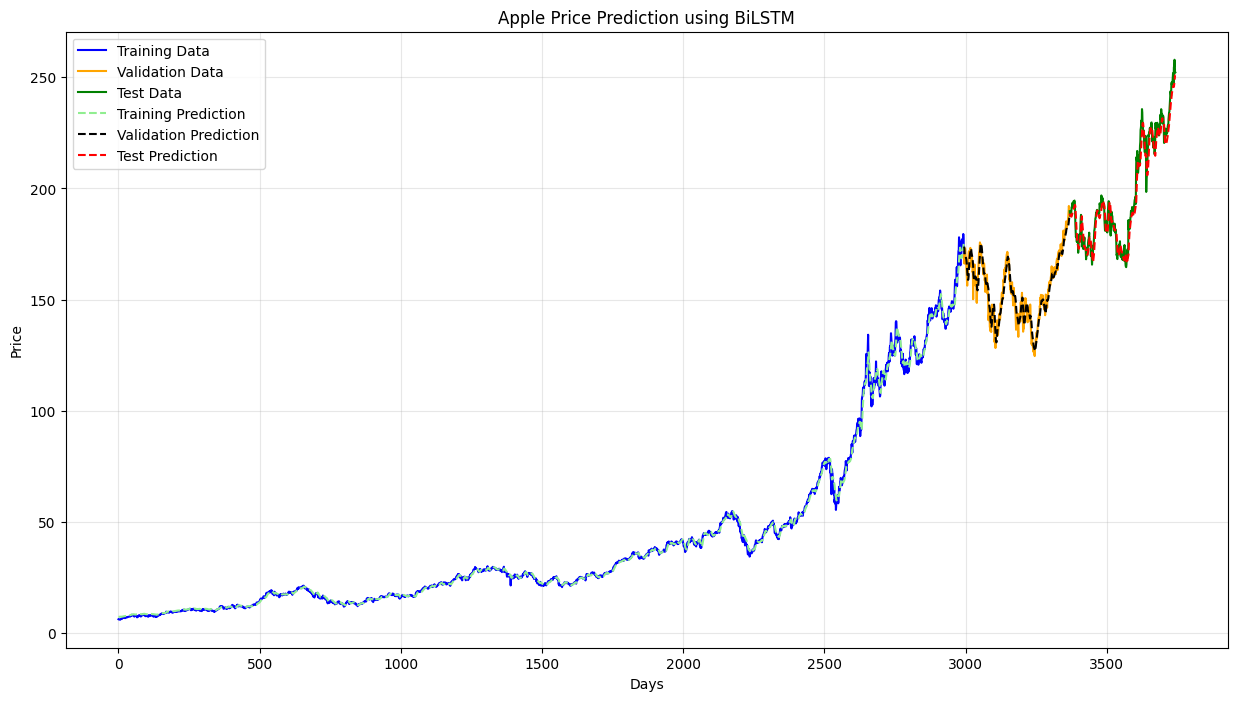


Model Performance Comparison:
    Model  Train MAE  Train MAPE (%)   Val MAE  Val MAPE (%)   Test MAE  \
0     RNN   1.244606        4.265570  4.121333      2.625505  14.823846   
1    LSTM   1.081593        3.228380  4.086441      2.688174   4.592173   
2     GRU   0.942310        2.631260  3.855337      2.491172   4.930694   
3  BiLSTM   0.877581        2.567834  3.365113      2.210145   3.804189   

   Test MAPE (%)  
0       7.013544  
1       2.277630  
2       2.427291  
3       1.899230  


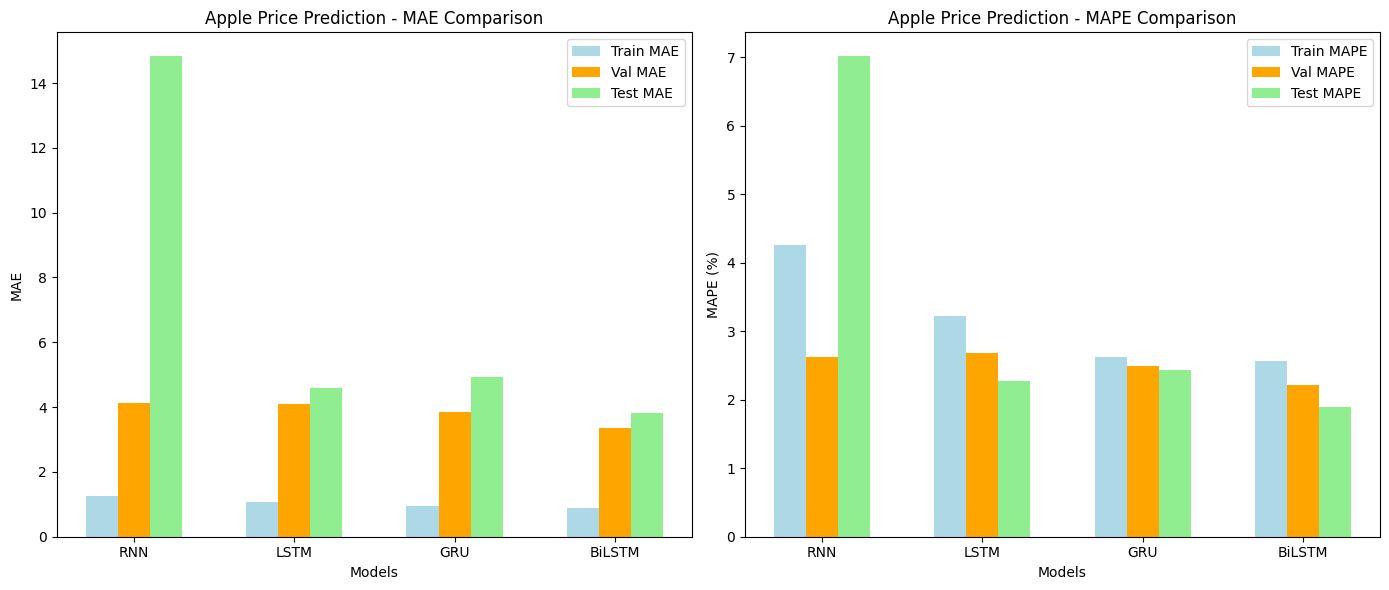

In [41]:


# Run all models
results, metrics = run_models(
    X_train, y_train, X_val, y_val, X_test, y_test,
    sequence_length=sequence_length,
    scaler=scaler,
    epochs=50,
    batch_size=32,
    stock_name="Apple"
)
